In [3]:
import numpy as np
inf=float("inf")

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import scipy.stats as st

import stablerank.srank as sr
import stablerank.geometry_objects_2020 as ge

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import _pickle as pickle

from ripser import ripser
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from PIL import Image

### Import Data

In [4]:
# loading the data

df=pd.read_csv('challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv', sep=',')
#df=pd.read_csv('challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv', sep=',',header=None)

In [5]:
# Removing duplicate values and reindexing

df.drop_duplicates(subset =[" pixels"], inplace = True)
df=df.reindex(range(0,len(df)-1))

# Embedding 2

## 1. Start with $H_0$

### 1.1 Calculate Example stable rank for one image

In [47]:
# Take the first picture as an example
pixel_values = [int(numeric_string) for numeric_string in df[" pixels"][3].split(' ')]

image_dummy = np.empty((48*48,3), int)
for i in range(0,len(image_dummy)):
    image_dummy[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values[i]/255)]

image_stacked = np.vstack(image_dummy)
image = sr.EucObject(image_stacked)

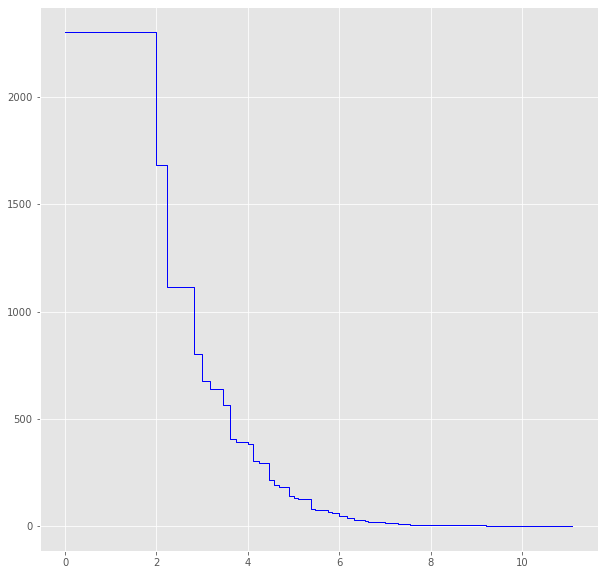

In [48]:
# specifying metric
metric = "euclidean"
metric_parameter = 3

# specifying clustering method
clustering_method = "single"


f1 = image.get_h0sr(metric = metric, metric_parameter = metric_parameter)


plt.figure(figsize=(10,10))

f1.plot(color ="blue")

### 1.2 Plot more $H_0$ stable ranks

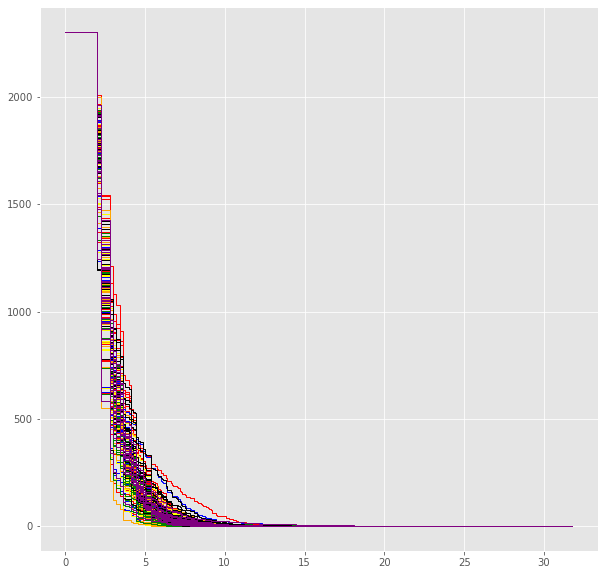

In [51]:
emotion_categories = [0,1,2,3,4,5,6]
#emotion_categories = [1,2,4]
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
colours=["red","blue","yellow","orange","green","black","purple"]

# specifying the number of pictures for subsampling
number_of_pictures = 25# How many pictures per subsampling

# specifying metric
metric = "euclidean"
metric_parameter = 100

# specifying clustering method
clustering_method = "single"

plt.figure(figsize=(10,10))

for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==e))[0]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]
    #rand_pos=pos
    
    # Calculate euclidean object for the first image
    pixel_values_1 = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[0]].split(' ')]
    
    image_dummy_1 = np.empty((48*48,3), int)
    
    for i in range(0,len(image_dummy_1)):
        # Try out different normalizations:
        # No normalization
        # image_dummy_1[i] = [(i-i%48)/48, i%48, pixel_values_1[i]/255]
        # Normalization
        # image_dummy_1[i] = [(i-i%48)/48, i%48, 47*pixel_values_1[i]/255]
        # Fully normalized
        # image_dummy_1[i] = [((i-i%48)/48)/47, (i%48)/47, pixel_values_1[i]/255]
        
        # Working best: All values between 0 and 100
        image_dummy_1[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_1[i]/255)]
        
    image_stacked_1 = np.vstack(image_dummy_1)
    image_1 = sr.EucObject(image_stacked_1)
    
    # Add the pcf to the overall pcf but weighted to get the overall average in the end
    f = image_1.get_h0sr(metric = metric, metric_parameter = metric_parameter)*(1/number_of_pictures)
    
    
    # Calculate stable rank for the remaining images
    for p in range(1,number_of_pictures):
        
        pixel_values_i = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[p]].split(' ')]
        image_dummy_i = np.empty((48*48,3), int)
        
        for i in range(0,len(image_dummy_i)):
            image_dummy_i[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_i[i]/255)]
            
        image_stacked_i = np.vstack(image_dummy_i)
        image_i = sr.EucObject(image_stacked_i)
        
        # Add the pcf to the overall pcf but weighted to get the overall average in the end
        # f = f + image_i.get_h0sr(metric = metric, metric_parameter = metric_parameter)*(1/number_of_pictures)
        
        # Plot single pcf
        f = image_i.get_h0sr(metric = metric, metric_parameter = metric_parameter)
        f.plot(color=colours[emotion_categories.index(e)])
    
    # plot the average pcf
    #f.plot(color=colours[emotion_categories.index(e)])

### --> Conclusion: There is no visible difference between the different categories with regards to $H_0$ homology

## 2. Higher Homologies

### 2.1 Compute the barcods for one image

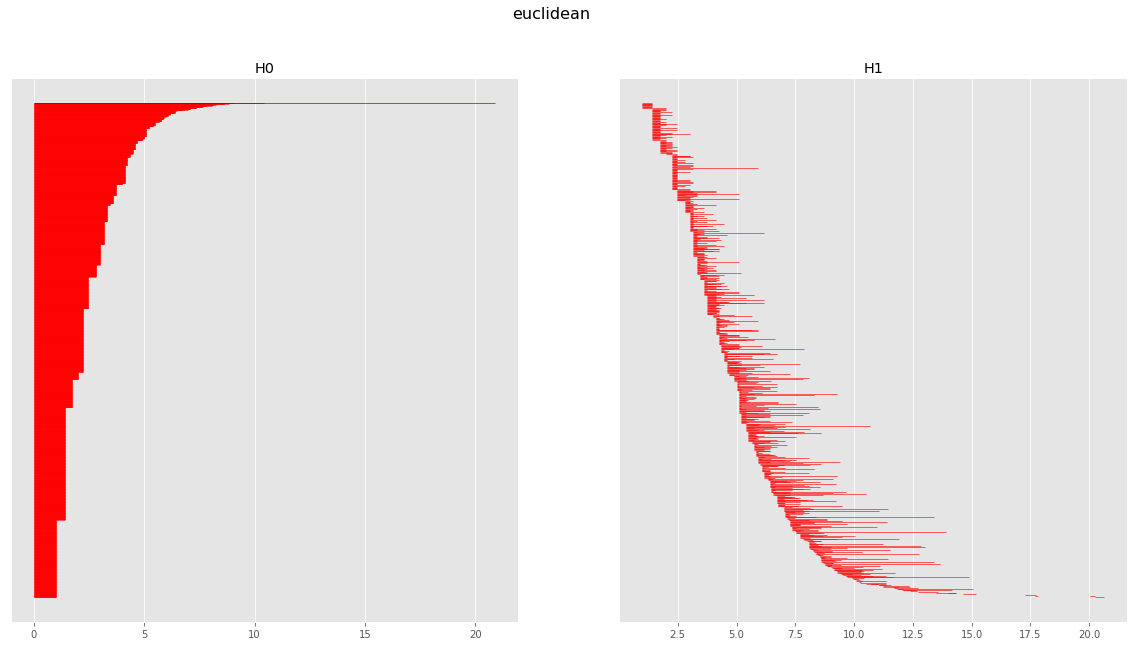

In [14]:
metrics = ["euclidean"]


D ={}
for m in metrics:
    D[m] = image.get_distance(metric = m)

maxdim = 1
coeff = 2
for m in metrics:
    bc = D[m].get_bc(maxdim = maxdim, coeff = coeff)
    fig=plt.figure(m, figsize = (20,10))
    fig.suptitle(m, fontsize=16)
    ax=plt.subplot(1,2,1)
    ax.set_title("H0")
    bc["H0"].plot()
    ax=plt.subplot(1,2,2)
    ax.set_title("H1")
    bc["H1"].plot()

### 2.2 Plot the stable rank for a single image

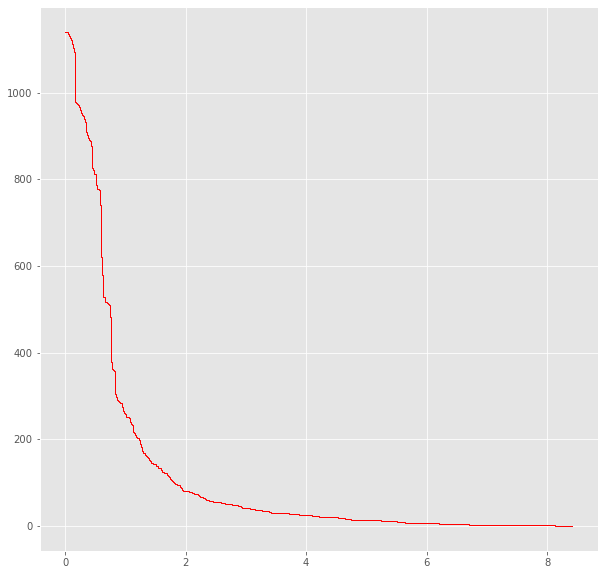

In [57]:
degree="H1"
b = image.get_bc(maxdim=1)
S = sr.bc_to_sr(b, degree)

plt.figure(figsize=(10,10))
S.plot(color = "red")

## 2.3 Plotting more stable ranks

##### Simply plotting the first images

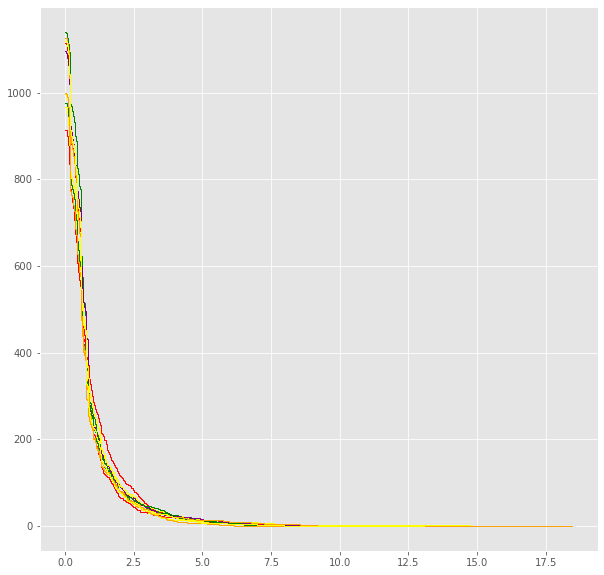

In [53]:
# number of stable ranks to plot 
k=10

# select homology and maxdim
degree="H1"
md=1

# colorcode emotions
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
colors=["red","blue","yellow","orange","green","black","purple"]


plt.figure(figsize=(10,10))

for u in range(0,k):
    pixel_values_it = [int(numeric_string) for numeric_string in df[" pixels"][u].split(' ')]

    image_dummy_it = np.empty((48*48,3), int)
    for i in range(0,len(image_dummy_it)):
        image_dummy_it[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_it[i]/255)]

    image_stacked_it = np.vstack(image_dummy_it)
    image_it = sr.EucObject(image_stacked_it)
    
    b_it = image_it.get_bc(maxdim=md)
    S_it = sr.bc_to_sr(b_it, degree)
    
    # get which emotion is expressed on the image
    emotion = int(df["emotion"][u])
    
    S_it.plot(color = colors[emotion])
    

##### Plotting an equal amount per category

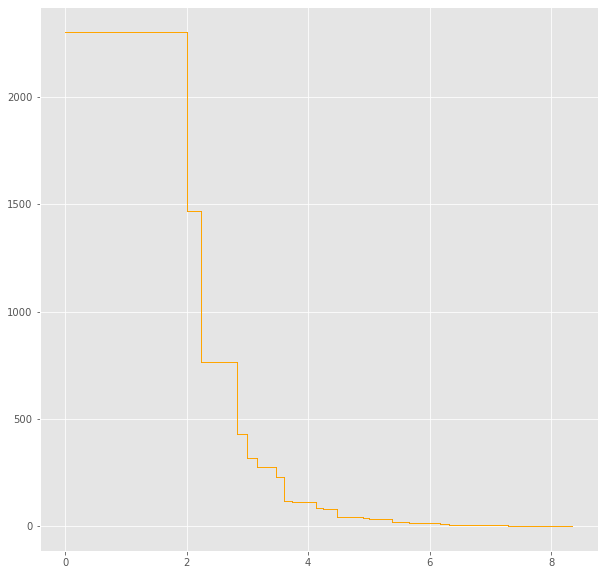

In [55]:
# Color code and select emotion categories
emotion_categories = [1,3]
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
colours=["red","blue","yellow","orange","green","black","purple"]

# specifying the number of pictures for subsampling
number_of_pictures = 5

# select homology and maxdim
degree="H0"
md=0

# specifying metric
metric = "euclidean"
metric_parameter = 1

# specifying clustering method
clustering_method = "single"

plt.figure(figsize=(10,10))

for e in emotion_categories:
    # Select random images for subsampling for emotion e
    pos = np.array(np.where(df["emotion"]==e))[0]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]
    
    # Calculate stable ranks
    for l in range(0,number_of_pictures):
        pixel_values_it = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[l]].split(' ')]

        image_dummy_it = np.empty((48*48,3), int)
        for i in range(0,len(image_dummy_it)):
            image_dummy_it[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_1[i]/255)]

        image_stacked_it = np.vstack(image_dummy_it)
        image_it = sr.EucObject(image_stacked_it)

        b_it = image_it.get_bc(maxdim=md)
        S_it = sr.bc_to_sr(b_it, degree)
        S_it.plot(color = colors[e])

### Average within different emotions

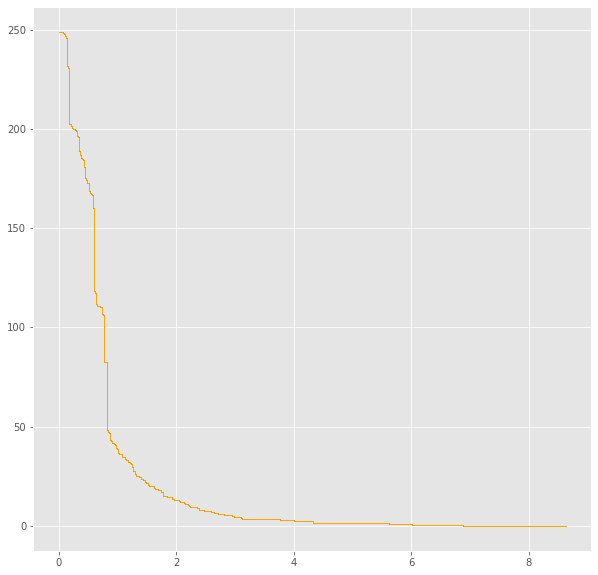

In [56]:
# Color code and select emotion categories
#emotion_categories = [0,1,2,3,4,5,6]
emotion_categories = [1,3]
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
colours=["red","blue","yellow","orange","green","black","purple"]

# specifying the number of pictures for subsampling
number_of_pictures = 5

# select homology and maxdim
degree="H1"
md=1

# specifying metric
metric = "euclidean"
metric_parameter = 1

# specifying clustering method
clustering_method = "single"

plt.figure(figsize=(10,10))

for e in emotion_categories:
    # Select random images for subsampling for emotion e
    pos = np.array(np.where(df["emotion"]==e))[0]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]
    
    # Calculate the stable rank for the first image which was selected
    pixel_values_it = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[0]].split(' ')]

    image_dummy_it = np.empty((48*48,3), int)
    for i in range(0,len(image_dummy_it)):
        image_dummy_it[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_1[i]/255)]

    image_stacked_it = np.vstack(image_dummy_it)
    image_it = sr.EucObject(image_stacked_it)
    
    b_it = image_it.get_bc(maxdim=md)
    S_it = sr.bc_to_sr(b_it, degree)*(1/number_of_pictures)
    
    # Calculate stable ranks for the remaining pictures
    for l in range(1,number_of_pictures):
        pixel_values_it = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[l]].split(' ')]

        image_dummy_it = np.empty((48*48,3), int)
        for i in range(0,len(image_dummy_it)):
            image_dummy_it[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_1[i]/255)]

        image_stacked_it = np.vstack(image_dummy_it)
        image_it = sr.EucObject(image_stacked_it)

        b_it = image_it.get_bc(maxdim=md)
        S_it = sr.bc_to_sr(b_it, degree)*(1/number_of_pictures)
    
    S_it.plot(color = colors[e])
    

## Saving PCNIF

##### Testing

In [107]:
S_cont = S.content
S2 = sr.Pcnif(s_cont)

In [132]:
# For testing: Storing a singel functions
index = 300
degree="H1"
md=1

# Compute the stable rank as above
pixel_values_ti = [int(numeric_string) for numeric_string in df[" pixels"][index].split(' ')]
image_dummy_ti = np.empty((48*48,3), int)
for i in range(0,len(image_dummy_ti)):
    image_dummy_ti[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_ti[i]/255)]

image_stacked_ti = np.vstack(image_dummy_ti)
image_ti = sr.EucObject(image_stacked_ti)

b_ti = image.get_bc(maxdim=md)
S_ti = sr.bc_to_sr(b_ti, degree)

content = S_ti.content

contents = []
contents.append(content)
contents.append(content)

indeces = []
indeces.append(index)
indeces.append(index)

data_test = {'old index':indeces, 'content':contents}
df_out_test = pd.DataFrame(data)

In [133]:
df_out_test.to_csv('Results/test.csv')

#### Exporting for one emotion

In [137]:
# Selecting one emotion
e = 0
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

# specifying the number of pictures for subsampling
number_of_pictures = 80

# select homology and maxdim
degree="H0"
md=0

# Set up empty arrays for the indices and contents
indices = []
contents = []

# Select random images for subsampling for emotion e
pos = np.array(np.where(df["emotion"]==e))[0]
rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]
    
# Calculate stable ranks
for l in range(0,number_of_pictures):
    pixel_values_it = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[l]].split(' ')]
    image_dummy_it = np.empty((48*48,3), int)
    for i in range(0,len(image_dummy_it)):
        image_dummy_it[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_1[i]/255)]

    image_stacked_it = np.vstack(image_dummy_it)
    image_it = sr.EucObject(image_stacked_it)

    b_it = image_it.get_bc(maxdim=md)
    S_it = sr.bc_to_sr(b_it, degree)
    
    indices.append(rand_pos[l])
    contents.append(S_it.content)
    
data = {'old index':indices, 'content':contents}
df_out = pd.DataFrame(data)
df_out.to_csv("Results/angry_80images_H0.csv")